In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [140]:
from matplotlib.lines import Line2D
import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import jax
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
from jax import lax

In [141]:
DATA_PATH = '../data/processed/data_processed.csv'
data = pd.read_csv(DATA_PATH)

In [142]:
data.columns

Index(['Unnamed: 0', 'machineID', 'datetime', 'voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count', 'comp1', 'comp2', 'comp3',
       'comp4', 'comp1_life', 'comp2_life', 'comp3_life', 'comp4_life', 'age',
       'model_model1', 'model_model2', 'model_model3', 'model_model4',
       'failure', 'comp1_fail', 'comp2_fail', 'comp3_fail', 'comp4_fail'],
      dtype='object')

In [143]:
data['datetime'] = pd.to_datetime(data.datetime)

In [144]:
data_per_id = data.loc[data.machineID==1]

In [145]:
data_cols = ['voltmean_3h', 'rotatemean_3h',
       'pressuremean_3h', 'vibrationmean_3h', 'voltsd_3h', 'rotatesd_3h',
       'pressuresd_3h', 'vibrationsd_3h', 'voltmean_24h', 'rotatemean_24h',
       'pressuremean_24h', 'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'error1count', 'error2count',
       'error3count', 'error4count', 'error5count','model_model1', 'model_model2', 'model_model3', 'model_model4']

target_cols = ['comp1_life', 'comp2_life', 'comp3_life', 'comp4_life']

In [146]:
N_features = len(data_cols)

In [147]:
X_df = data_per_id[data_cols]
X = X_df.values

y_df = [data_per_id[target_col] for target_col in target_cols]

for df_ in y_df:
    df_.dropna(inplace=True, axis=0)

/tmp/ipykernel_6655/1067028610.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_.dropna(inplace=True, axis=0)


In [148]:
a = data_per_id['comp1_life']
a = a.dropna()
y = a.values

In [149]:
train_size_pc = 0.85
train_idx = np.floor(train_size_pc*X.shape[0]).astype(int)

X_train = X[:train_idx]
X_test = X[train_idx:]

y_train = y[:train_idx]
y_test = y[train_idx:]

In [150]:
N_train = y_train.shape[0]
N_test = y_test.shape[0]

In [151]:
y.shape

(2912,)

### Model

In [152]:
def f(carry, inputs):
    
    (noise_t, x) = inputs
    
    betas, z_prev, tau, w = carry
    
    z_t = 0
    for i in range(len(betas)):
        z_t += betas[i]* z_prev[i]
        
    z_t += jnp.dot(w, x) #+ tau*noise_t
    

    z_prev_cp = z_prev[:]
    
    for i in range(len(z_prev)-1):
        if i==0:
            z_prev[i] = z_t
        else:
            z_prev[i] = z_prev_cp[i+1]
            
    assert len(z_prev) == len(z_prev_cp), 'Constructed orevious states lists not of same size'
        
    
    return (betas, z_prev, tau, w), z_t

In [153]:
def model(T, T_forecast, obs=None, inputs=None, n_latent=1):
    """ Define priors over beta1, beta2, tau, noises, sigma, z_prev1 and z_prev2 (keep the shapes in mind)
    # Your code here
    """
    
    tau = numpyro.sample(name="tau", fn=dist.HalfCauchy(scale=3.))
    noises = numpyro.sample("noises", fn=dist.Normal(0., 1.), sample_shape=(T+T_forecast,))
    sigma = numpyro.sample(name="sigma", fn=dist.HalfCauchy(scale=3.))
    
    n,p = inputs.shape
    
    w = numpyro.sample(name="inp_mtrx", fn=dist.Normal(loc=np.zeros(p), scale=5.)) # how to estimate scale?
    
#     beta2 = numpyro.sample(name="beta_2", fn=dist.Normal(loc=0., scale=5.))
#     beta1 = numpyro.sample(name="beta_1", fn=dist.Normal(loc=0., scale=5.))
    
    betas = [numpyro.sample(name=f"beta_{i+1}", fn=dist.Normal(loc=0., scale=5.)) for i in range(n_latent)]
    
#     z_prev1 = numpyro.sample(name="z_1", fn=dist.Normal(loc=0., scale=3.))
#     z_prev2 = numpyro.sample(name="z_2", fn=dist.Normal(loc=0., scale=3.))
    
    z_prev = [numpyro.sample(name=f"z_{i+1}", fn=dist.Normal(loc=0., scale=3.)) for i in range(n_latent)]
#     z_prev = [numpyro.sample(name=f"z_{i+1}", fn=dist.Poisson(.5)) for i in range(n_latent)]
    
    
    
    """ Propagate the dynamics forward using jax.lax.scan
    carry = (beta1, beta2, z_prev1, z_prev2, tau)
    z_collection = [z_prev1, z_prev2]
    # Your code here
    """
    carry = (betas, z_prev, tau, w)
    z_collection = z_prev
    carry, zs_exp = lax.scan(f, carry, [noises, inputs], T+T_forecast)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """ Sample the observed_y (y_obs) and predicted_y (y_pred) - note that you don't need a pyro.plate!
    # Your code here
    """
        
    numpyro.sample(name="y_obs", fn=dist.Normal(loc=z_collection[:T], scale=sigma), obs=obs[:T])
    numpyro.sample(name="y_pred", fn=dist.Normal(loc=z_collection[T:], scale=sigma), obs=None)
    return z_collection

In [154]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

n_states = 14
n_previous = 1
T = N_train
T_forecast = N_test


X_t = np.concatenate([X_train[n_previous:,:], X_test], axis=0)


nuts_kernel = NUTS(model=model, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=T, T_forecast=T_forecast, inputs=X_t, obs=y_train, n_latent=30)

sample: 100%|█████████| 4000/4000 [04:17<00:00, 15.54it/s, 1 steps of size 5.00e-03. acc. prob=0.02]


In [155]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
      beta_1      0.96      0.01      0.96      0.95      0.97      3.47      1.85
     beta_10      1.80      0.01      1.81      1.78      1.82      2.96      1.95
     beta_11     -0.36      0.01     -0.37     -0.37     -0.35      4.27      1.56
     beta_12      0.57      0.00      0.57      0.56      0.57      5.90      1.00
     beta_13     -1.94      0.00     -1.94     -1.95     -1.94      6.71      1.14
     beta_14      0.79      0.01      0.79      0.78      0.79      2.96      2.51
     beta_15     -0.52      0.00     -0.52     -0.52     -0.51      3.46      1.84
     beta_16     -1.30      0.01     -1.31     -1.32     -1.28      6.11      1.13
     beta_17     -2.44      0.02     -2.44     -2.48     -2.40      3.00      2.12
     beta_18      1.63      0.01      1.63      1.62      1.65      3.12      1.89
     beta_19      2.18      0.00      2.18      2.17      2.18      4.94      1.37
   

In [156]:
hmc_samples = {k: v for k, v in mcmc.get_samples().items()}

In [157]:
q = hmc_samples["y_pred"]
q_mean = q.mean(axis=0).reshape(-1,)
q_std = q.std(axis=0).reshape(-1,)
y_pred_025 = q_mean - 1.96*q_std
y_pred_975 = q_mean + 1.96*q_std
y_pred_mean = q_mean

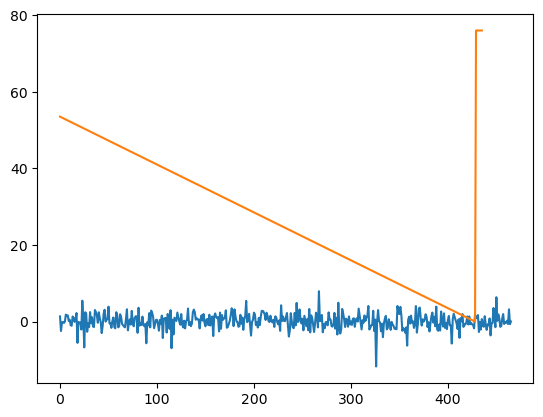

In [158]:
plt.plot(y_pred_mean)
plt.plot(y_test)

In [159]:
y_pred_mean.shape, y_test.shape

((466,), (436,))

In [160]:
q = hmc_samples["y_obs"]
q_mean = q.mean(axis=0).reshape(-1,)
q_std = q.std(axis=0).reshape(-1,)
y_obs_025 = q_mean - 1.96*q_std
y_obs_975 = q_mean + 1.96*q_std
y_obs_mean = q_mean

KeyError: 'y_obs'

In [ ]:
plt.plot(y_train)

In [ ]:
plt